## Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()


## Plots of energy production

Shows the difference in energy production at different locations

                     pv_measurement
time                               
2019-06-02 22:00:00            0.00
2019-06-02 23:00:00            0.00
2019-06-03 00:00:00            0.00
2019-06-03 01:00:00            0.00
2019-06-03 02:00:00           19.36


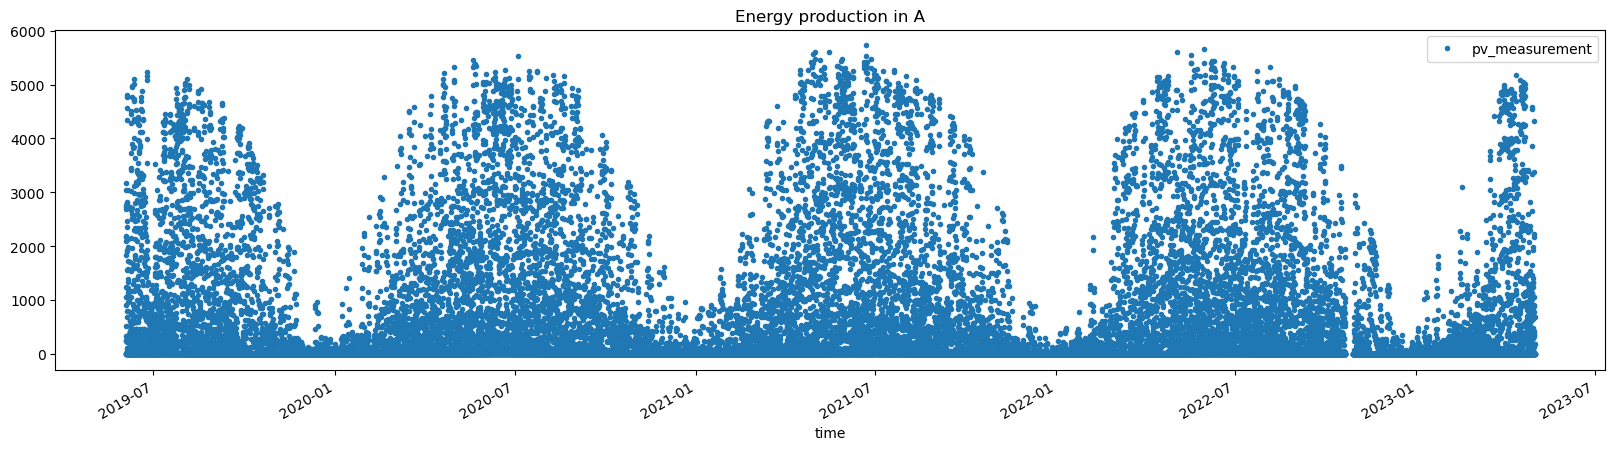

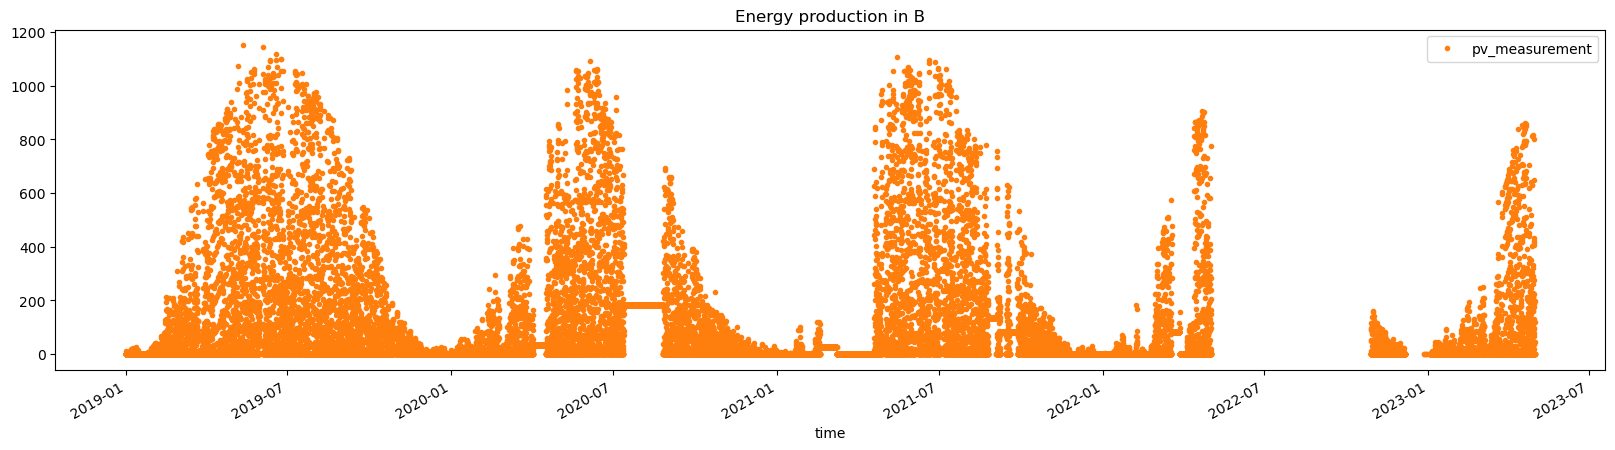

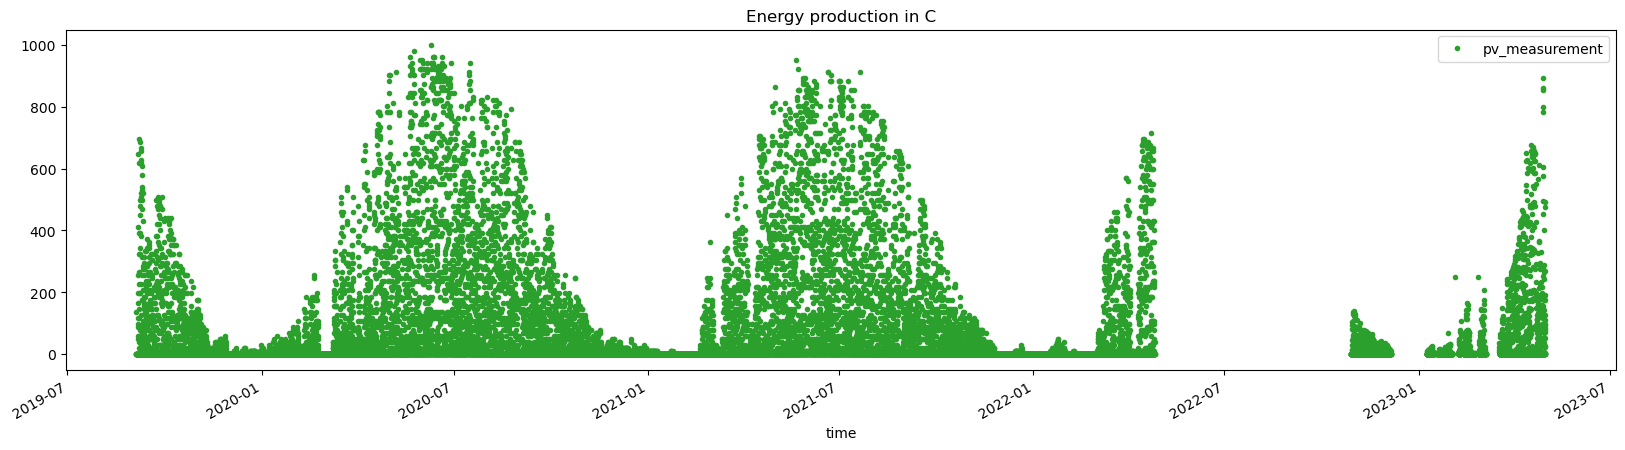

In [113]:
def load_and_plot_energy_production(dataset_path, title, color_index):
    df = pd.read_parquet(dataset_path)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.plot(
        style='.',
        figsize=(20, 5),
        color=color_pal[color_index],
        title=title
    )
    return df

# Load and plot each dataset, while storing the DataFrames
train_targets_A = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet', 
    'Energy production in A', 
    0
)

train_targets_B = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/B/train_targets.parquet', 
    'Energy production in B', 
    1
)

train_targets_C = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/train_targets.parquet', 
    'Energy production in C', 
    2
)
print(train_targets_A.head())



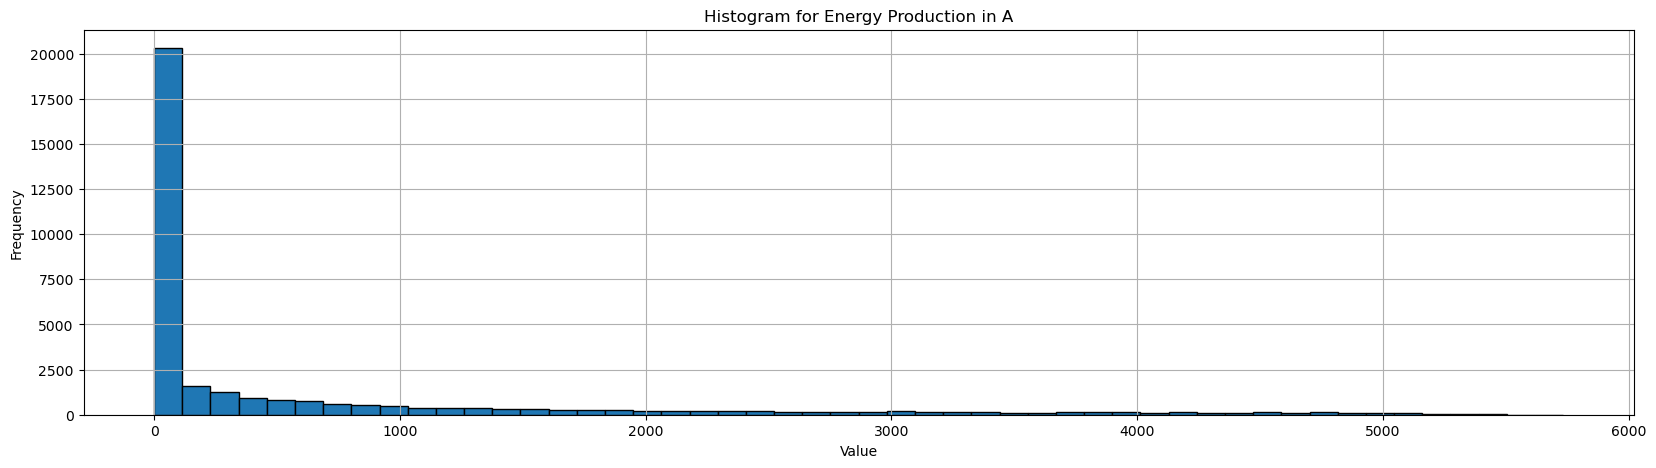

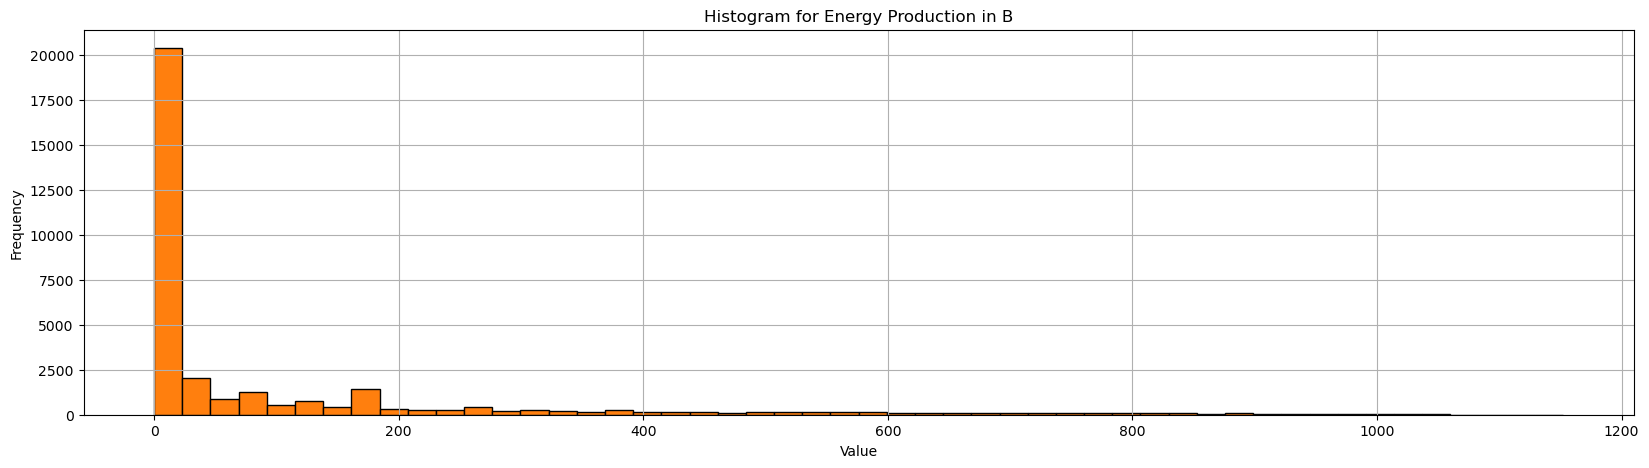

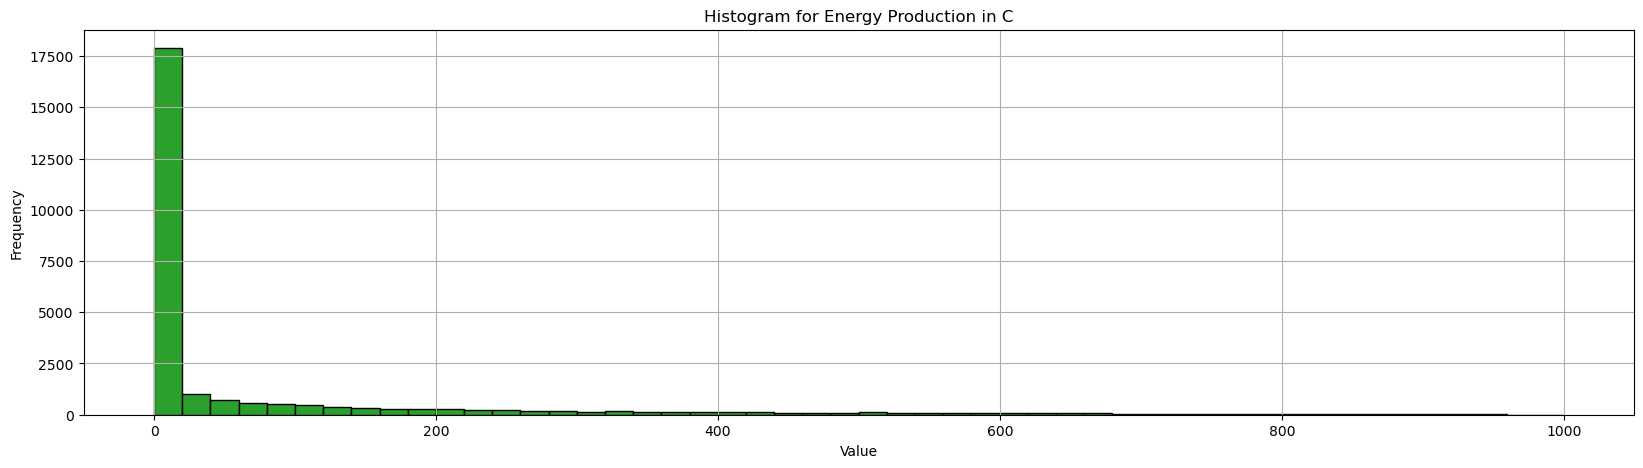

In [114]:
def plot_histogram(df, title, color_index):
    df.hist(
        figsize=(20, 5),
        color=color_pal[color_index],
        bins=50,
        edgecolor='black'
    )
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot histograms for each dataset
plot_histogram(train_targets_A, 'Histogram for Energy Production in A', 0)
plot_histogram(train_targets_B, 'Histogram for Energy Production in B', 1)
plot_histogram(train_targets_C, 'Histogram for Energy Production in C', 2)


In [115]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
train_targets_A = train_targets_A.sort_index()

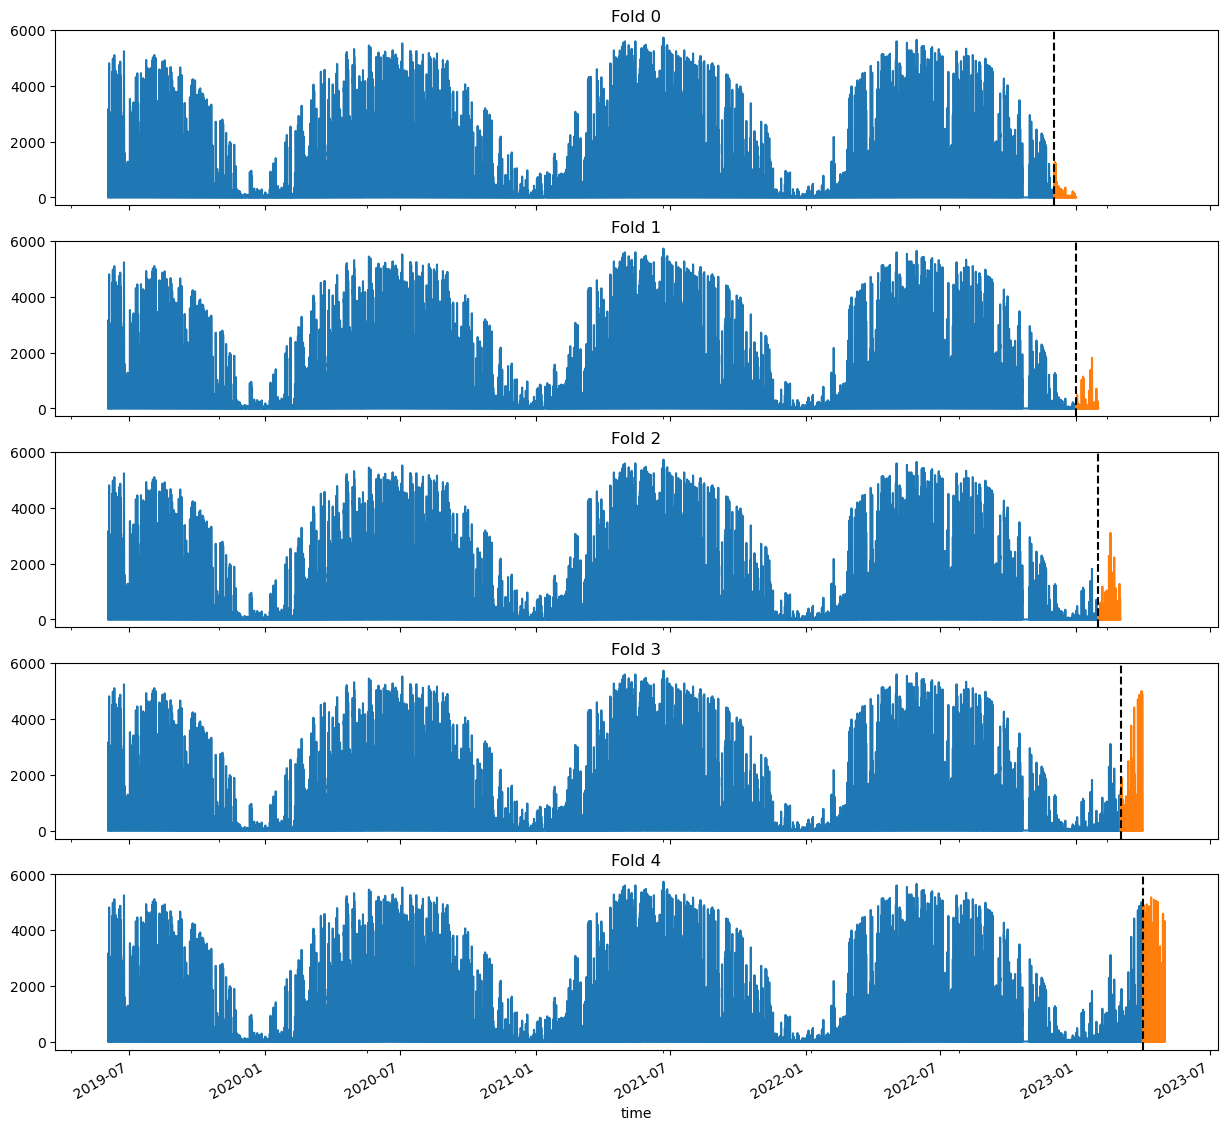

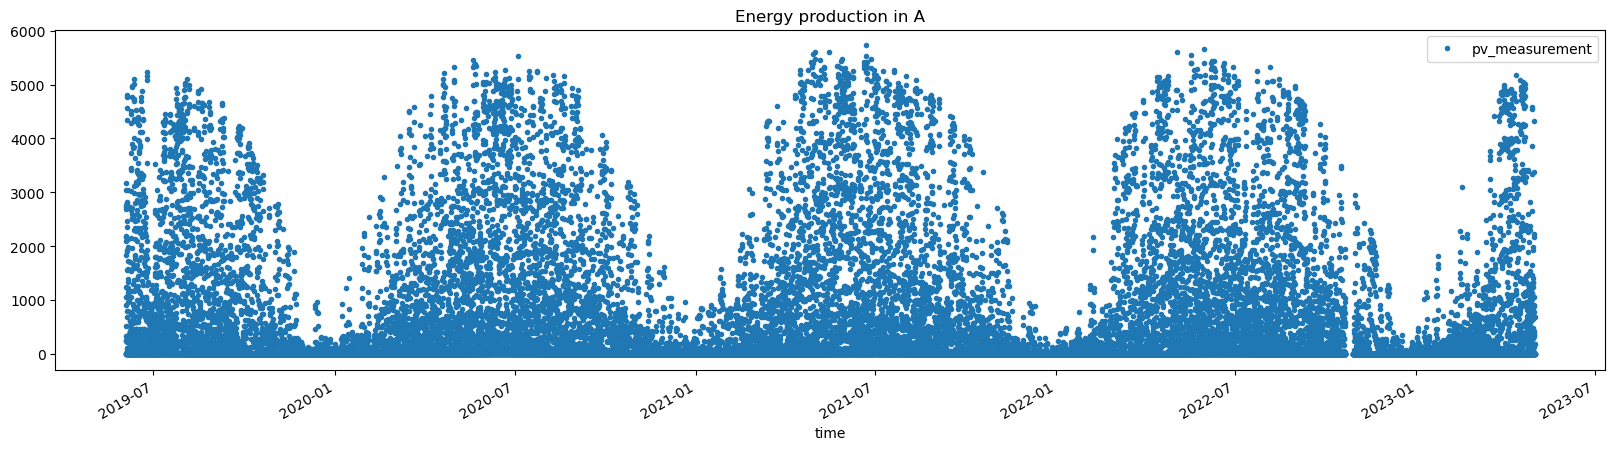

In [116]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_targets_A):
    train = train_targets_A.iloc[train_idx]
    test = train_targets_A.iloc[val_idx]

    train['pv_measurement'].plot(ax=axs[fold],
                                 label='train', title=f'Fold {fold}')
    test['pv_measurement'].plot(ax=axs[fold], label='test')

    axs[fold].axvline(test.index.min(), color='black', linestyle='--')  
    fold += 1

train_targets_A = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet', 
    'Energy production in A', 
    0
)



In [117]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

train_targets_A = create_features(train_targets_A)

In [118]:
def add_lags(df):
    target_map = df['pv_measurement'].to_dict()
    df['lag 1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return train_targets_A


In [119]:
train_targets_A = add_lags(train_targets_A)
train_targets_A.tail()

,pv_measurement,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag 1,lag 2,lag 3
time,,,,,,,,,,,,
2023-04-30 19:00:00,9.02,19,6,2,4,2023,120,30,17,16.72,60.28,6.16
2023-04-30 20:00:00,0.00,20,6,2,4,2023,120,30,17,0.00,0.00,0.00
2023-04-30 21:00:00,0.00,21,6,2,4,2023,120,30,17,0.00,0.00,0.00
2023-04-30 22:00:00,0.00,22,6,2,4,2023,120,30,17,0.00,0.00,0.00
2023-04-30 23:00:00,0.00,23,6,2,4,2023,120,30,17,0.00,0.00,0.00


In [120]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
train_targets_A = train_targets_A.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(train_targets_A):
    train = train_targets_A.iloc[train_idx]
    test = train_targets_A.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag 1', 'lag 2', 'lag 3']
    TARGET = 'pv_measurement'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[18:07:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1348.54208	validation_1-rmse:128.71572
[100]	validation_0-rmse:939.70144	validation_1-rmse:121.08819
[18:07:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1333.04396	validation_1-rmse:181.41795
[100]	validation_0-rmse:930.28321	validation_1-rmse:156.10919
[113]	validation_0-rmse:907.73947	validation_1-rmse:163.83495
[18:07:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1318.21380	va